<a href="https://colab.research.google.com/github/jquach410/hinf6210/blob/main/Assignment_6_B00680884.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 5

# Task 1. Prepare the data

• Include all the required code from assignments 1 and 2 and apply any changes that you think are necessary.

• Explain what changes you made to the code from assignment 1, and what was the purpose of these changes, if any.

In [ ]:
# Load the Drive helper and mount

import pandas as pd
import numpy as np
from google.colab import drive

drive.mount('/content/drive')
path = "/content/drive/My Drive/Colab Notebooks/HINF6210/data/Dataset_Jack.csv"

np.random.seed(0) # set seed now since we are randomizing with splitting

data = pd.read_csv(path, na_values='?') # specify that ? are missing  

# clean names
data.columns=data.columns.str.lower().str.replace(' ','_')

data = data.replace({'t': True, 'f': False, 'M': True, 'F': False}) 
# turn strings into a boolean
# male = T, female = F, doing this to maintain any missing values 

# rename because we turned sex into a boolean
data = data.rename(columns={"sex": "sex_male"}) # more informative name

# dummy code referral_source
data = pd.get_dummies(data, columns = ['referral_source'])
# apply name cleaning again
data.columns=data.columns.str.lower().str.replace(' ','_')

# convert columns to appropriate data type
data=data.convert_dtypes()

# replace pandas NAs with numpy NaNs
data = data.replace(pd.NA, np.nan)

# clean and create target
data[['target','class_number']] = data['class'].str.split(".", expand=True)
data['class_number'] = data['class_number'].str.replace('|','')
# code target to 1/0
data['target'] = np.where(data['target'] == "negative", 0, 1)
# convert target to boolean
data=data.convert_dtypes()

# remove some uneeded columns
data=data.drop(['class', 'class_number', 'tbg', 'tbg_measured'], axis = 1)

Mounted at /content/drive


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# performing MICE imputation, with hyperparameter values based on assignment 2
my_imputer = IterativeImputer(
  missing_values=np.nan, # specify missing here to make sure we use np NaNs
  random_state=0, # keep random number generator as 0 (there was a typo from assignment 2 that set it as 3)
  n_nearest_features=3, # due to analysis from assignment 2
  max_iter=2, # changed from 1 to 2 based on the analysis from assignment 2
  sample_posterior=True, # need to set to true for this iterative imputer to work
)

imputed_data = pd.DataFrame(
  my_imputer.fit_transform(data), # impute
  columns = data.columns # specify column names as it returns numbers
)

# fixing datatypes
imputed_data=imputed_data.convert_dtypes()
imputed_data['target'] = imputed_data['target'].astype(bool) # so that kfold strat will work
imputed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3076 entries, 0 to 3075
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        3076 non-null   Float64
 1   sex_male                   3076 non-null   Float64
 2   on_thyroxine               3076 non-null   Int64  
 3   query_on_thyroxine         3076 non-null   Int64  
 4   on_antithyroid_medication  3076 non-null   Int64  
 5   sick                       3076 non-null   Int64  
 6   pregnant                   3076 non-null   Int64  
 7   thyroid_surgery            3076 non-null   Int64  
 8   i131_treatment             3076 non-null   Int64  
 9   query_hypothyroid          3076 non-null   Int64  
 10  query_hyperthyroid         3076 non-null   Int64  
 11  lithium                    3076 non-null   Int64  
 12  goitre                     3076 non-null   Int64  
 13  tumor                      3076 non-null   Int64

## Split data

In [ ]:
from sklearn.model_selection import train_test_split

y = imputed_data.loc[:, 'target'] # target
x = imputed_data.drop(['target'], axis=1) # features (drop target only)

# do an 80/20 split
x_train, x_test, y_train, y_test = train_test_split(
  x,
  y, 
  train_size=0.8, 
  test_size=None,
  random_state=10, # use random seed 10 for rest of document
  shuffle=True,
  stratify=y # to retain similar proportions in the samples
)

## Standardize data

Models often perform better when data is standardized

In [ ]:
from sklearn.preprocessing import StandardScaler

# Initiate scaler
sc = StandardScaler()
# Standardize the training dataset
x_train_transformed = pd.DataFrame(sc.fit_transform(x_train),index=x_train.index, columns=x_train.columns)
# Standardized the testing dataset
x_test_transformed = pd.DataFrame(sc.transform(x_test),index=x_test.index, columns=x_test.columns)
# Summary statistics after standardization
x_train_transformed.describe().T

,count,mean,std,min,25%,50%,75%,max
age,2460.0,7.076544e-17,1.000203,-2.453551,-0.763181,0.154448,0.734004,19.472962
sex_male,2460.0,2.599547e-17,1.000203,-3.793353,-0.671325,-0.671325,1.486774,2.249372
on_thyroxine,2460.0,-5.776770e-17,1.000203,-0.367709,-0.367709,-0.367709,-0.367709,2.719541
query_on_thyroxine,2460.0,-1.444193e-17,1.000203,-0.112971,-0.112971,-0.112971,-0.112971,8.851827
on_antithyroid_medication,2460.0,1.877450e-17,1.000203,-0.092791,-0.092791,-0.092791,-0.092791,10.776960
sick,2460.0,4.910255e-17,1.000203,-0.189181,-0.189181,-0.189181,-0.189181,5.285941
pregnant,2460.0,-2.888385e-17,1.000203,-0.116606,-0.116606,-0.116606,-0.116606,8.575865
thyroid_surgery,2460.0,1.444193e-17,1.000203,-0.121867,-0.121867,-0.121867,-0.121867,8.205689
i131_treatment,2460.0,-1.155354e-17,1.000203,-0.126921,-0.126921,-0.126921,-0.126921,7.878891
query_hypothyroid,2460.0,4.693626e-17,1.000203,-0.269003,-0.269003,-0.269003,-0.269003,3.717429


We can see now that all the means are zero

# Task 2. 
Support Vector Machines classifier

•Train and test a SVC from the svmmodule of scikit-learn (link). 

•Use RandomizedSearchCV to tune the hyperparameters of the classifier.

•Report the performance of the best classifier from the randomized search usingthe most suitable scoring metric(s) (link) for your dataset.

In [ ]:
from sklearn.svm import SVC
svc = SVC(random_state=10)
params = svc.get_params()
params_df = pd.DataFrame(params, index=[0])
params_df.T

,0
C,1.0
break_ties,False
cache_size,200
class_weight,None
coef0,0.0
decision_function_shape,ovr
degree,3
gamma,scale
kernel,rbf
max_iter,-1


Above are all the hyperparameters to be tuned. The most critical hyperparameters for SVM are kernel, C, and gamma, so I will focus on tuning these.

We can see that the default hyperparameter has the C value of 1, the gamma value of scale, and the kernel value of rbf.

In [ ]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_we

## Tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

# List of values
C_range = np.logspace(-10, 10, 21) # searching many values around the default
gamma_range = np.logspace(-10, 10, 21)

param_grid = { 
    # Regularization parameter.
    "C": C_range,
    # Kernel type
    "kernel": ['rbf', 'poly'],
    # Gamma is the Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
    "gamma": gamma_range.tolist()+['scale', 'auto'] # also include scale and auto
    }

# Set up scoring for evaluation
scoring = ['f1']

# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

# Define random search
svc_random_search = RandomizedSearchCV(estimator=svc, 
                           param_distributions=param_grid, 
                           n_iter=500, # it takes more time to do more iterations, have to balance time and results
                           scoring=scoring, 
                           refit='f1', # specify we want to get best hyperparams with f1
                           n_jobs=-1, 
                           cv=kfold, 
                           random_state = 10,
                           verbose=0) # set this for faster

svc_random_search.fit(x_train_transformed, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
                   estimator=SVC(random_state=10), n_iter=500, n_jobs=-1,
                   param_distributions={'C': array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
       1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10]),
                                        'gamma': [1e-10, 1e-09, 1e-08, 1e-07,
                                                  1e-06, 1e-05, 0.0001, 0.001,
                                                  0.01, 0.1, 1.0, 10.0, 100.0,
                                                  1000.0, 10000.0, 100000.0,
                                                  1000000.0, 10000000.0,
                                                  100000000.0, 1000000000.0,
                                                  10000000000.0, 'scale',
                                                  'auto'],
             

In [ ]:
svc_random_search.best_params_

{'kernel': 'rbf', 'gamma': 0.001, 'C': 10000.0}

## Evaluation metrics

The randomized search has provided the best hyperparameters above. Now we will use this to report the performance using several scoring metrics.

Our target is very imbalanced, so we should not use accuracy as an evaluation metric for classifiers. There are a couple of useful metrics for imbalanced data including: 

* AUC
* Cohen's Kappa
* F1 Score
* Jaccard Score

So we'll try all of these to see how our classifier does. We'll also include recall

In [ ]:
from sklearn.metrics import (
    cohen_kappa_score,
    f1_score,
    roc_auc_score,
    jaccard_score,
    recall_score
)

# loop over several metrics for the base model and the optimized model
for metric in [cohen_kappa_score, f1_score, roc_auc_score, jaccard_score, recall_score]:
        score_name = metric.__name__
        base_model = SVC(random_state=10)
        base_model.fit(x_train_transformed, y_train)
        
        # base model
        base_predict = base_model.predict(x_test_transformed)
        print('For base model:')
        base_score = metric(y_test, base_predict)
        print('\t', score_name, ':', base_score.round(4))

        #model with best hyperparameters
        best_random = svc_random_search.best_estimator_

        random_predict = best_random.predict(x_test_transformed)
        print('For the best combination of hyperparameters of model:')
        random_score = metric(y_test, random_predict)
        print('\t', score_name, ':', random_score.round(4))
        
        print('Improvement of {:0.2f}%.'.format( 100 * (random_score - base_score) / base_score), "\n\n")

For base model:
	 cohen_kappa_score : 0.4688
For the best combination of hyperparameters of model:
	 cohen_kappa_score : 0.8692
Improvement of 85.40%. 


For base model:
	 f1_score : 0.4935
For the best combination of hyperparameters of model:
	 f1_score : 0.8807
Improvement of 78.46%. 


For base model:
	 roc_auc_score : 0.6638
For the best combination of hyperparameters of model:
	 roc_auc_score : 0.9111
Improvement of 37.26%. 


For base model:
	 jaccard_score : 0.3276
For the best combination of hyperparameters of model:
	 jaccard_score : 0.7869
Improvement of 140.21%. 


For base model:
	 recall_score : 0.3276
For the best combination of hyperparameters of model:
	 recall_score : 0.8276
Improvement of 152.63%. 




Using randominzed search significantly improved 5 different evaluation metrics for the SVM.

# Task 3.

Neural network classifier

•Train and test an MLPClassifierfrom the neural_networkmodule of scikit-learn (link). 

•Use RandomizedSearchCVto tune the hyperparameters of the classifier.•Report the performance of the best classifier from the randomized search usingthe most suitable scoring metric(s) (link) for your dataset.

•Plot the learning curve for the neural network classifier.

•Explain what you observe from the learning curve for thisclassifier.

## Tuning

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(random_state=10)
params = mlp.get_params()
params_df = pd.DataFrame(params, index=[0])
params_df.T

,0
activation,relu
alpha,0.0001
batch_size,auto
beta_1,0.9
beta_2,0.999
early_stopping,False
epsilon,0.0
hidden_layer_sizes,100
learning_rate,constant
learning_rate_init,0.001


In [ ]:
param_grid = {
    'hidden_layer_sizes': [(150,100,50), (120,80,40), (100,50,30)],
    'max_iter': [ 100, 150, 200, 250, 300],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

# Set up scoring for evaluation
scoring = ['f1']

# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

# Define random search
mlp_random_search = RandomizedSearchCV(estimator=mlp, 
                           param_distributions=param_grid, 
                           n_iter=100, # it takes more time to do more iterations, have to balance time and results
                           scoring=scoring, 
                           refit='f1', # specify we want to get best hyperparams with f1
                           n_jobs=-1, 
                           cv=kfold, 
                           random_state = 10,
                           verbose=0) # set this for faster

mlp_random_search.fit(x_train_transformed, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
                   estimator=MLPClassifier(random_state=10), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'activation': ['tanh', 'relu'],
                                        'alpha': [0.0001, 0.001, 0.05],
                                        'hidden_layer_sizes': [(150, 100, 50),
                                                               (120, 80, 40),
                                                               (100, 50, 30)],
                                        'learning_rate': ['constant',
                                                          'adaptive'],
                                        'max_iter': [100, 150, 200, 250, 300],
                                        'solver': ['sgd', 'adam']},
                   random_state=10, refit='f1', scoring=['f1'])

In [ ]:
mlp_random_search.best_params_

{'solver': 'adam',
 'max_iter': 200,
 'learning_rate': 'constant',
 'hidden_layer_sizes': (150, 100, 50),
 'alpha': 0.001,
 'activation': 'tanh'}

## Evaluation

In [ ]:
# loop over several metrics for the base model and the optimized model
for metric in [cohen_kappa_score, f1_score, roc_auc_score, jaccard_score, recall_score]:
        score_name = metric.__name__
        base_model = mlp
        base_model.fit(x_train_transformed, y_train)
        
        # base model
        base_predict = base_model.predict(x_test_transformed)
        print('For base model:')
        base_score = metric(y_test, base_predict)
        print('\t', score_name, ':', base_score.round(4))

        #model with best hyperparameters
        best_random = mlp_random_search.best_estimator_

        random_predict = best_random.predict(x_test_transformed)
        print('For the best combination of hyperparameters of model:')
        random_score = metric(y_test, random_predict)
        print('\t', score_name, ':', random_score.round(4))
        
        print('Improvement of {:0.2f}%.'.format( 100 * (random_score - base_score) / base_score), "\n\n")

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


For base model:
	 cohen_kappa_score : 0.8762
For the best combination of hyperparameters of model:
	 cohen_kappa_score : 0.8668
Improvement of -1.08%. 




/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


For base model:
	 f1_score : 0.8868
For the best combination of hyperparameters of model:
	 f1_score : 0.8793
Improvement of -0.84%. 




/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


For base model:
	 roc_auc_score : 0.9043
For the best combination of hyperparameters of model:
	 roc_auc_score : 0.9334
Improvement of 3.22%. 




/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


For base model:
	 jaccard_score : 0.7966
For the best combination of hyperparameters of model:
	 jaccard_score : 0.7846
Improvement of -1.51%. 


For base model:
	 recall_score : 0.8103
For the best combination of hyperparameters of model:
	 recall_score : 0.8793
Improvement of 8.51%. 




/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


The hyperparameter tuning only improved the recall and auc score. The other scores were only marginally worse.

The base model also generated a warning that the model did not converge (i.e. find a local minima). This demonstrates the necessity to tune hyperparameters.

## Learning curves

### f1

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


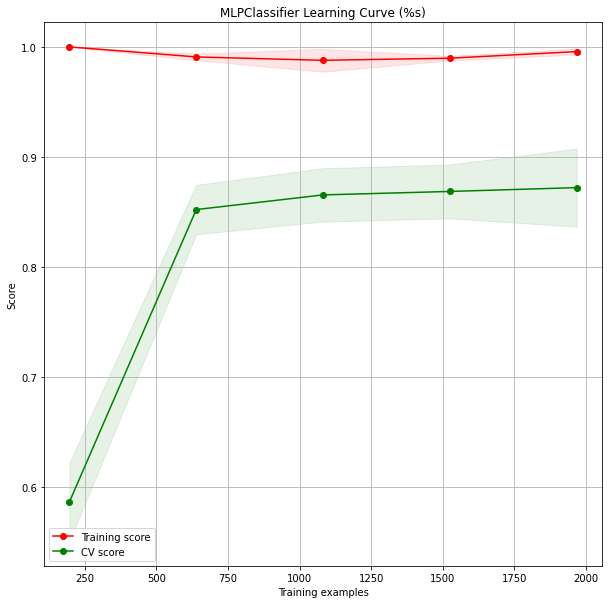

In [ ]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 1, figsize=(10, 10))

# specifying to use stratified k fold
# although it's already the default so don't actually need to 
skf=StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

ax = axs

ax.set_title('MLPClassifier Learning Curve (%s)')
ax.set_xlabel("Training examples")
ax.set_ylabel("Score")

train_sizes, train_scores, test_scores = learning_curve(mlp_random_search.best_estimator_, 
                                                        x_train_transformed, 
                                                        y_train, 
                                                        cv=skf,
                                                        scoring='f1',
                                                        random_state=0)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
ax.grid(True)
ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                  train_scores_mean + train_scores_std, alpha=0.1,
                  color="r")
ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                  test_scores_mean + test_scores_std, alpha=0.1, color="g")
ax.plot(train_sizes, train_scores_mean, 'o-', color="r",
          label="Training score")
ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
          label="CV score")
ax.legend(loc="best")

plt.show()

### jaccard

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


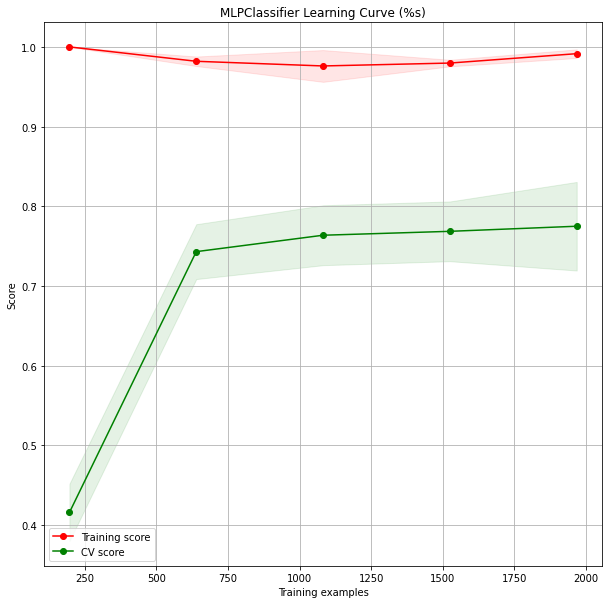

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10))

# specifying to use stratified k fold
# although it's already the default so don't actually need to 
skf=StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

ax = axs

ax.set_title('MLPClassifier Learning Curve (%s)')
ax.set_xlabel("Training examples")
ax.set_ylabel("Score")

train_sizes, train_scores, test_scores = learning_curve(mlp_random_search.best_estimator_, 
                                                        x_train_transformed, 
                                                        y_train, 
                                                        cv=skf,
                                                        scoring='jaccard',
                                                        random_state=0)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
ax.grid(True)
ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                  train_scores_mean + train_scores_std, alpha=0.1,
                  color="r")
ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                  test_scores_mean + test_scores_std, alpha=0.1, color="g")
ax.plot(train_sizes, train_scores_mean, 'o-', color="r",
          label="Training score")
ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
          label="CV score")
ax.legend(loc="best")

plt.show()

### roc auc

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


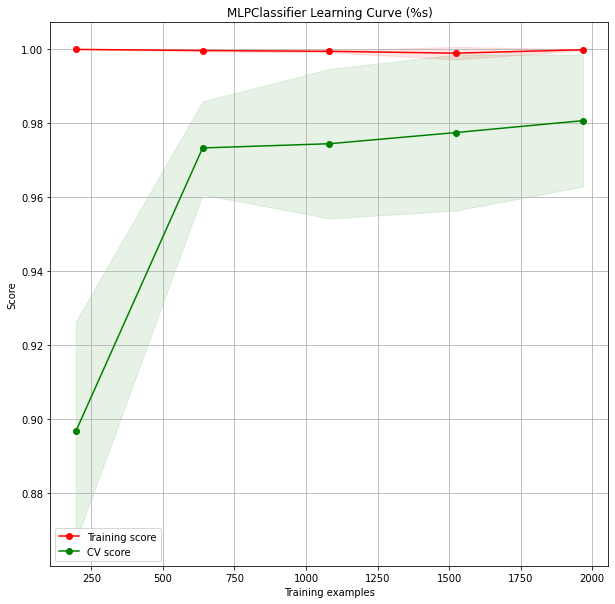

In [ ]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 1, figsize=(10, 10))

# specifying to use stratified k fold
# although it's already the default so don't actually need to 
skf=StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

ax = axs

ax.set_title('MLPClassifier Learning Curve (%s)')
ax.set_xlabel("Training examples")
ax.set_ylabel("Score")

train_sizes, train_scores, test_scores = learning_curve(mlp_random_search.best_estimator_, 
                                                        x_train_transformed, 
                                                        y_train, 
                                                        cv=skf,
                                                        scoring='roc_auc',
                                                        random_state=0)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
ax.grid(True)
ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                  train_scores_mean + train_scores_std, alpha=0.1,
                  color="r")
ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                  test_scores_mean + test_scores_std, alpha=0.1, color="g")
ax.plot(train_sizes, train_scores_mean, 'o-', color="r",
          label="Training score")
ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
          label="CV score")
ax.legend(loc="best")

plt.show()

Based on the learning curves with 5-fold cross-validated training and test scores, the models learned on the non-cross validated training data tend to overfit the data. 

All the evaluation metrics are consistently lower in the CV sets than the original training set. In addition, for a couple of metrics, they improve but taper off as more data is learned.

Overall, these learning curves indicate that cross-validation is a crucial step to make sure our model is more generalizable to other data. It also demonstrates that more data will make the algorithm perform better, but 